In [2]:
from dotenv import load_dotenv
import os

load_dotenv(verbose=True)
key = os.getenv('OPENAI_API_KEY')

### PDF 문서 검색 Retrieval Chain 생성

In [3]:
from rag.pdf import PDFRetrievalChain

# PDF 문서를 로드
pdf = PDFRetrievalChain(['data/SPRI_AI_Brief_2023년12월호_F.pdf']).create_chain()

pdf_retriever = pdf.retriever       # retriever 생성
pdf_chain = pdf.chain               # pdf retriever chain 생성

### State 정의

`State`: Graph 의 노드와 노드들을 끼리 공유하는 상태를 정의합니다.
<br>

State에 관련성(relevance) 체크 결과를 추가합니다.

In [4]:
from typing import Annotated, TypedDict, List
from langgraph.graph.message import add_messages

class GraphState(TypedDict):               
    question: Annotated[List[str], add_messages]    # 질문
    context: Annotated[str, 'context']              # 문서의 검색 결과
    answer: Annotated[str, 'Answer']                # 답변
    messages: Annotated[list, add_messages ]        # 메시지
    relevance: Annotated[str, 'Relevance']          # 관련성

### 노드 정의

`Nodes`: 각 단계를 처리하는 노드입니다. Python 함수로 만들게 되고 함수의 입력과 출력이 상태(State) 값입니다. <br>

`State` 를 입력으로 받아 정의된 로직을 수행한 후 업데이트된 State를 반환합니다.

In [5]:
from langchain_teddynote.messages import messages_to_history
from rag.utils import format_docs

In [6]:
from langchain_teddynote.evaluator import GroundednessChecker
from langchain_teddynote.tools.tavily import TavilySearch
from langchain_openai import ChatOpenAI

In [7]:
def retrieve_document(state: GraphState) -> GraphState:             # 문서 검색 노드 
            
    latest_question = state['question'][-1].content                 # state 에서 질문(question)을 가져온다.
    
    retrieved_docs = pdf_retriever.invoke(latest_question)           # pdf_retriever를 사용해서 문서 검색하여 관련성 있는 문서를 찾습니다.
    retrieved_docs = format_docs(retrieved_docs)                     # 검색된 문서를 모두 문자열로 변경 (프롬프트의 입력이 된다)

    return GraphState(context=retrieved_docs)                               

In [8]:
def llm_answer(state: GraphState) -> GraphState:
    
    latest_question = state['question'][-1].content                 # state 에서 질문(question)을 가져온다.
    context = state['context']                                      # state 에서 검색된 문서의 내용(context)을 가져온다.
    
    response = pdf_chain.invoke(                                    # pdf_chain을 호출해서 대답을 만듭니다.
        {
            'question': latest_question,                            # 질문      
            'context': context,                                     # 검색된 문서의 내용
            'chat_history': messages_to_history(state['messages'])  
        }
    )

    return {                                                       
        'answer': response,                                                 # 생성된 답변을 answer에 저장
        'messages': [('user', latest_question), ('assistant', response)]    # user의 질문과 생성된 답변을 messages에 저장
    }

In [9]:
def relevance_check(state: GraphState) -> GraphState:                       # 관련성 평가 노드
    
    question_retrival_relevat = GroundednessChecker(                        # 관련성 평가기를 생성. 
        llm = ChatOpenAI(api_key=key, model_name='gpt-4o-mini'), 
        target='question-retrieval'                                         # 검색된 문서와 질문을 관성성 평가한다.검색된 문서가 질문에 답변하기 위한 내용이 포함되어 있는지 체크하는 평가기.
    ).create()                                                              

    response = question_retrival_relevat.invoke(                            # 관련성 체크 실행 (yes or no)
        {"question": state["question"][-1].content, "context": state["context"]}
    )

    return {"relevance": response.score}

In [10]:
def is_relevant(state: GraphState) -> GraphState:

    if state['relevance']=='yes':
        return 'relevant'
    else:
        return 'not relevant'

In [11]:
def web_search(state: GraphState) -> GraphState:
    
    tavily_tool = TavilySearch()                # 검색 도구 생성
    search_query = state['question']

    search_result = tavily_tool.search(
        query=search_query,                     # 검색 쿼리
        topic='general',                        # 일반 주제
        max_results=3,                          # 최대 검색 결과
        format_output=True,                     # 결과 포맷팅
    )
    
    return {'context': search_result}

In [12]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

# Query Rewrite 프롬프트 정의
re_write_prompt = PromptTemplate(
    template="""Reformulate the given question to enhance its effectiveness for vectorstore retrieval.

- Analyze the initial question to identify areas for improvement such as specificity, clarity, and relevance.
- Consider the context and potential keywords that would optimize retrieval.
- Maintain the intent of the original question while enhancing its structure and vocabulary.

# Steps

1. **Understand the Original Question**: Identify the core intent and any keywords.
2. **Enhance Clarity**: Simplify language and ensure the question is direct and to the point.
3. **Optimize for Retrieval**: Add or rearrange keywords for better alignment with vectorstore indexing.
4. **Review**: Ensure the improved question accurately reflects the original intent and is free of ambiguity.

# Output Format

- Provide a single, improved question.
- Do not include any introductory or explanatory text; only the reformulated question.

# Examples

**Input**: 
"What are the benefits of using renewable energy sources over fossil fuels?"

**Output**: 
"How do renewable energy sources compare to fossil fuels in terms of benefits?"

**Input**: 
"How does climate change impact polar bear populations?"

**Output**: 
"What effects does climate change have on polar bear populations?"

# Notes

- Ensure the improved question is concise and contextually relevant.
- Avoid altering the fundamental intent or meaning of the original question.


[REMEMBER] Re-written question should be in the same language as the original question.

# Here is the original question that needs to be rewritten:
{question}
""",
    input_variables=["generation", "question"],
)

question_rewriter = (
    re_write_prompt | ChatOpenAI(api_key=key, model="gpt-4o-mini", temperature=0) | StrOutputParser()
)

In [13]:
def query_rewrite(state: GraphState) -> GraphState:
    
    latest_question = state["question"][-1].content
    question_rewritten = question_rewriter.invoke({"question": latest_question})

    return {"question": question_rewritten}

### 그래프 정의

`Edges`: 현재 State를 기반으로 다음에 실행할 Node를 결정하는 Python 함수.<br>

일반 엣지, 조건부 엣지 등이 있습니다.

In [14]:
from langgraph.checkpoint.memory import MemorySaver
from langchain_teddynote.graphs import visualize_graph
from langgraph.graph import StateGraph, END

In [15]:
######### 1. 그래프 생성 #########

workflow = StateGraph(GraphState)

In [16]:
######### 2. 노드 정의  #########

# 노드 이름, 함수 이름을 넣으서 노트를 추가
workflow.add_node('retrieve', retrieve_document)
workflow.add_node('relevance_check', relevance_check)
workflow.add_node('llm_answer', llm_answer)
workflow.add_node('web_search', web_search)
workflow.add_node('query_rewrite', query_rewrite)

In [17]:
######### 3. 그래프 엣지(Edge) 추가  #########

workflow.add_edge("query_rewrite", "retrieve")      # 질문 재작성 에서 검색(retrieve)
workflow.add_edge("retrieve", "relevance_check")    # 검색(retrieve) 에서 관련성 체크

In [18]:
workflow.add_conditional_edges(                         # 조건부 엣지
    'relevance_check',                                  # 관련성 체크 노드에서 나온 결과를 is_relevant 함수에 전달
    is_relevant,                                        # 분기 함수(yse: relevant, no: not relevant)
    {
        'relevant': 'llm_answer',                       # 관련성이 있으면 답변을 생성합니다. llm_answer 실행
        'not relevant': 'retrieve',                     # 관련성이 없으면 다시 검색합니다.   retrieve 실행
    },
)

workflow.add_edge('web_search', 'llm_answer')           # 웹 검색 에서 답변
workflow.add_edge('llm_answer', END)                    # 답변(llm_answer) 에서 종료(END)

In [19]:
######### 4. 그래프 진입점  #########

workflow.set_entry_point('query_rewrite')

In [20]:
######### 5. 체크 포인터 설정  #########

memory = MemorySaver()

In [21]:
######### 6. 그래프 컴파일(compile)  #########

app = workflow.compile(checkpointer=memory)

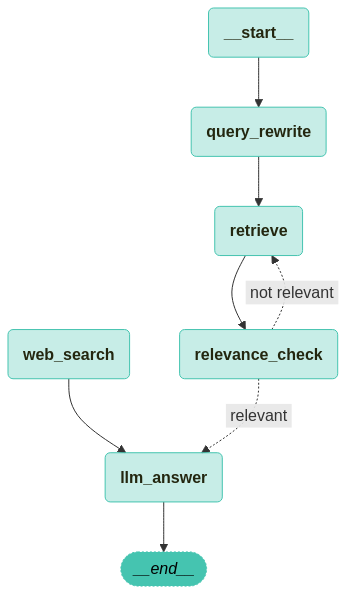

In [22]:
visualize_graph(app)

### 그래프 실행

- `config` 파라미터는 그래프 실행 시 필요한 정보를 전달.

    - `recursion_limit`: 그래프 실행 시 노드 반복의 횟수를 설정.
    - `thread_id`: 대화 세션을 구분하는 데 사용. 

<br>

- `inputs`: 그래프 실행 시 필요한 입력정보를 전달.

In [23]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import invoke_graph, stream_graph, random_uuid

In [24]:
config = RunnableConfig(                        # config 설정
    recursion_limit=20,                         # 최대 20개의 노드까지 방문.
    configurable={'thread_id': random_uuid()}   # thread_id 설정
)

# 질문
inputs = GraphState(question='앤스로픽 투자 금액')


i = 1

for chunk in app.stream(inputs, config=config, stream_mode="updates"):
    print(f"===== for 시작 {i} =====")

    j = 1

    for state_key, state_value in chunk.items():
        print(f"== for 시작 {i} - {j} ==")
        print(f"state_key : {state_key }")
        
        if state_key == 'query_rewrite':
            print('------------------------------')
            print(f"🔄 [Node] 질문 재작성 노드 🔄")
            print(f"{state_value['question']}")
            print('------------------------------')
            print()
        elif state_key == 'retrieve':
            print('------------------------------')
            print(f"🔄 [Node] 문서 검색 노드 🔄")
            print(f"{state_value['context']}")
            print('------------------------------')
            print()
        elif state_key == 'llm_answer':
            print('------------------------------')
            print(f"🔄 [Node] 답변 생성 노드 🔄")
            print(f"{state_value['answer']}")
            print('------------------------------')
            print()
        elif state_key == 'relevance_check':
            print('------------------------------')
            print(f"🔄 [Node] 관련성 평가 노드 🔄")
            print(f"{state_value['relevance']}")
            print('------------------------------')
            print()
        elif state_key == 'web_search':
            print('------------------------------')
            print(f"🔄 [Node] 웹 검색 노드 🔄")
            print(f"{state_value['context']}")
            print('------------------------------')
            print()

        # print(f"state_value: \n {state_value}")
        print(f"== for  끝 {i} - {j}==")

        j=j+1
    
    print(f"===== for 끝 {i} =====")
    i=i+1

===== for 시작 1 =====
== for 시작 1 - 1 ==
state_key : query_rewrite
------------------------------
🔄 [Node] 질문 재작성 노드 🔄
앤스로픽에 대한 투자 금액은 얼마인가요?
------------------------------

== for  끝 1 - 1==
===== for 끝 1 =====
===== for 시작 2 =====
== for 시작 2 - 1 ==
state_key : retrieve
------------------------------
🔄 [Node] 문서 검색 노드 🔄
<document><content>£구글, 앤스로픽에 최대 20억 달러 투자 합의 및 클라우드 서비스 제공
n 구글이 2023년 10월 27일 앤스로픽에 최대 20억 달러를 투자하기로 합의했으며, 이 중 5억
달러를 우선 투자하고 향후 15억 달러를 추가로 투자할 방침
∙ 구글은 2023년 2월 앤스로픽에 이미 5억 5,000만 달러를 투자한 바 있으며, 아마존도 지난 9월
앤스로픽에 최대 40억 달러의 투자 계획을 공개
∙ 한편, 2023년 11월 8일 블룸버그 보도에 따르면 앤스로픽은 구글의 클라우드 서비스 사용을 위해
4년간 30억 달러 규모의 계약을 체결</content><source>data/SPRI_AI_Brief_2023년12월호_F.pdf</source><page>14</page></document>
<document><content>1. 정책/법제 2. 기업/산업 3. 기술/연구 4. 인력/교육
구글, 앤스로픽에 20억 달러 투자로 생성 AI 협력 강화
KEY Contents
n 구글이 앤스로픽에 최대 20억 달러 투자에 합의하고 5억 달러를 우선 투자했으며, 앤스로픽은
구글과 클라우드 서비스 사용 계약도 체결
n 3대 클라우드 사업자인 구글, 마이크로소프트, 아마존은 차세대 AI 모델의 대표 기업인
앤스로픽 및 오픈AI와 협력을 확대하는 추세
£구글, 앤스로픽에 최대 20억 

In [25]:
def invoke_graph_(graph=app, inputs=inputs, config=config):
    for chunk in app.stream(inputs, config=config, stream_mode="updates"):
        print(f"==" * 50)
        
        for state_key, state_value in chunk.items():      
            if state_key == 'query_rewrite':
                print('------------------------------')
                print(f"🔄 [Node] 질문 재작성 노드 🔄")
                print(f"{state_value['question']}")
                print('------------------------------')
            elif state_key == 'retrieve':
                print('------------------------------')
                print(f"🔄 [Node] 문서 검색 노드 🔄")
                print(f"{state_value['context']}")
                print('------------------------------')
            elif state_key == 'llm_answer':
                print('------------------------------')
                print(f"🔄 [Node] 답변 생성 노드 🔄")
                print(f"{state_value['answer']}")
                print('------------------------------')
            elif state_key == 'relevance_check':
                print('------------------------------')
                print(f"🔄 [Node] 관련성 평가 노드 🔄")
                print(f"{state_value['relevance']}")
                print('------------------------------')
            elif state_key == 'web_search':
                print('------------------------------')
                print(f"🔄 [Node] 웹 검색 노드 🔄")
                print(f"{state_value['context']}")
                print('------------------------------')
            
        print(f"==" * 50)
        print()

In [26]:
config = RunnableConfig(                        # config 설정
    recursion_limit=20,                         # 최대 20개의 노드까지 방문.
    configurable={'thread_id': random_uuid()}   # thread_id 설정
)

# 질문
inputs = GraphState(question='앤스로픽 투자 금액')

invoke_graph_(graph=app, inputs=inputs, config=config)

------------------------------
🔄 [Node] 질문 재작성 노드 🔄
앤스로픽에 대한 투자 금액은 얼마인가요?
------------------------------

------------------------------
🔄 [Node] 문서 검색 노드 🔄
<document><content>£구글, 앤스로픽에 최대 20억 달러 투자 합의 및 클라우드 서비스 제공
n 구글이 2023년 10월 27일 앤스로픽에 최대 20억 달러를 투자하기로 합의했으며, 이 중 5억
달러를 우선 투자하고 향후 15억 달러를 추가로 투자할 방침
∙ 구글은 2023년 2월 앤스로픽에 이미 5억 5,000만 달러를 투자한 바 있으며, 아마존도 지난 9월
앤스로픽에 최대 40억 달러의 투자 계획을 공개
∙ 한편, 2023년 11월 8일 블룸버그 보도에 따르면 앤스로픽은 구글의 클라우드 서비스 사용을 위해
4년간 30억 달러 규모의 계약을 체결</content><source>data/SPRI_AI_Brief_2023년12월호_F.pdf</source><page>14</page></document>
<document><content>1. 정책/법제 2. 기업/산업 3. 기술/연구 4. 인력/교육
구글, 앤스로픽에 20억 달러 투자로 생성 AI 협력 강화
KEY Contents
n 구글이 앤스로픽에 최대 20억 달러 투자에 합의하고 5억 달러를 우선 투자했으며, 앤스로픽은
구글과 클라우드 서비스 사용 계약도 체결
n 3대 클라우드 사업자인 구글, 마이크로소프트, 아마존은 차세대 AI 모델의 대표 기업인
앤스로픽 및 오픈AI와 협력을 확대하는 추세
£구글, 앤스로픽에 최대 20억 달러 투자 합의 및 클라우드 서비스 제공</content><source>data/SPRI_AI_Brief_2023년12월호_F.pdf</source><page>14</page></document>
<document><content>4년간 30억 달러 규모의 계약을 체결
∙ 오픈AI 창업자 그룹의

In [27]:
import sys
import time

def stream_graph_(graph=app, inputs=inputs, config=config):
    for chunk in app.stream(inputs, config=config, stream_mode="updates"):
        print(f"==" * 50)
        
        for state_key, state_value in chunk.items():                  
            if state_key == 'query_rewrite':
                print('------------------------------')
                print(f"🔄 [Node] 질문 재작성 노드 🔄")
                print(f"{state_value['question']}")
                print('------------------------------')

            elif state_key == 'retrieve':
                print('------------------------------')
                print(f"🔄 [Node] 문서 검색 노드 🔄")
                print(f"{state_value['context']}")
                print('------------------------------')
            elif state_key == 'llm_answer':
                print('------------------------------')
                print(f"🔄 [Node] 답변 생성 노드 🔄")
                
                for char in state_value['answer']:
                    sys.stdout.write(char)
                    sys.stdout.flush()
                    time.sleep(0.01)

                print('------------------------------')
            elif state_key == 'relevance_check':
                print('------------------------------')
                print(f"🔄 [Node] 관련성 평가 노드 🔄")
                print(f"{state_value['relevance']}")
                print('------------------------------')

            elif state_key == 'web_search':
                print('------------------------------')
                print(f"🔄 [Node] 웹 검색 노드 🔄")
                print(f"{state_value['context']}")
                print('------------------------------')
                
        print(f"==" * 50)
        print()

In [28]:
config = RunnableConfig(                        # config 설정
    recursion_limit=20,                         # 최대 20개의 노드까지 방문.
    configurable={'thread_id': random_uuid()}   # thread_id 설정
)

# 질문
inputs = GraphState(question='앤스로픽 투자 금액')

stream_graph_(graph=app, inputs=inputs, config=config)

------------------------------
🔄 [Node] 질문 재작성 노드 🔄
앤스로픽에 대한 투자 금액은 얼마인가요?
------------------------------

------------------------------
🔄 [Node] 문서 검색 노드 🔄
<document><content>£구글, 앤스로픽에 최대 20억 달러 투자 합의 및 클라우드 서비스 제공
n 구글이 2023년 10월 27일 앤스로픽에 최대 20억 달러를 투자하기로 합의했으며, 이 중 5억
달러를 우선 투자하고 향후 15억 달러를 추가로 투자할 방침
∙ 구글은 2023년 2월 앤스로픽에 이미 5억 5,000만 달러를 투자한 바 있으며, 아마존도 지난 9월
앤스로픽에 최대 40억 달러의 투자 계획을 공개
∙ 한편, 2023년 11월 8일 블룸버그 보도에 따르면 앤스로픽은 구글의 클라우드 서비스 사용을 위해
4년간 30억 달러 규모의 계약을 체결</content><source>data/SPRI_AI_Brief_2023년12월호_F.pdf</source><page>14</page></document>
<document><content>1. 정책/법제 2. 기업/산업 3. 기술/연구 4. 인력/교육
구글, 앤스로픽에 20억 달러 투자로 생성 AI 협력 강화
KEY Contents
n 구글이 앤스로픽에 최대 20억 달러 투자에 합의하고 5억 달러를 우선 투자했으며, 앤스로픽은
구글과 클라우드 서비스 사용 계약도 체결
n 3대 클라우드 사업자인 구글, 마이크로소프트, 아마존은 차세대 AI 모델의 대표 기업인
앤스로픽 및 오픈AI와 협력을 확대하는 추세
£구글, 앤스로픽에 최대 20억 달러 투자 합의 및 클라우드 서비스 제공</content><source>data/SPRI_AI_Brief_2023년12월호_F.pdf</source><page>14</page></document>
<document><content>4년간 30억 달러 규모의 계약을 체결
∙ 오픈AI 창업자 그룹의